# Python Tutorial - How to work with OceanWatch data in Python

This tutorial will show the steps to grab data in ERDDAP from Python, how to work with NetCDF files in Python and how to make some maps and time-series od chlorophyll-a concentration around the main Hawaiian islands

## 1. Downlading data from Python

Because ERDDAP includes RESTful services, you can download data listed on any ERDDAP platform from Python using the URL structure. 

For example, the following page allows you to subset monthly sea surface temperature (SST) data:
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.html

Select your region and date range of interest, then select the '.nc' (NetCDF) file type and click on "Just Generate the URL".

![](erddap.png)

In this specific example, the URL we generated is :
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2018-01-01T12:00:00Z):1:(2018-12-01T12:00:00Z)][(17):1:(30)][(195):1:(210)]

In Python, run the following to download the data using the generated URL :


In [1]:
import urllib.request
url="https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0_monthly.nc?analysed_sst[(2018-01-01T12:00:00Z):1:(2018-12-01T12:00:00Z)][(17):1:(30)][(195):1:(210)]"
urllib.request.urlretrieve(url, "sst.nc")

('sst.nc', <http.client.HTTPMessage at 0x1d99ed7e1c8>)

# 2. Importing NetCDF4 data in Python

Now that we've downloaded the data locally, we can import it and extract our variables of interest.

The xarray package makes it very convenient to work with NetCDF files. Documentation is available here:
http://xarray.pydata.org/en/stable/why-xarray.html

In [2]:
import xarray as xr
import netCDF4 as nc

- Open the file and load it as an xarray dataset:

In [3]:
ds = xr.open_dataset('sst.nc',decode_cf=False)

- examine the data structure:

In [4]:
ds

<xarray.Dataset>
Dimensions:       (latitude: 261, longitude: 301, time: 12)
Coordinates:
  * time          (time) float64 1.515e+09 1.517e+09 ... 1.541e+09 1.544e+09
  * latitude      (latitude) float32 17.02 17.08 17.12 ... 29.92 29.98 30.02
  * longitude     (longitude) float32 195.0 195.1 195.1 ... 209.9 210.0 210.0
Data variables:
    analysed_sst  (time, latitude, longitude) float64 ...
Attributes: (12/64)
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This product is designed to improve on and re...
    contributor_name:           NOAA Coral Reef Watch program
    contributor_role:           Collecting source data and deriving products;...
    Conventions:                CF-1.6, ACDD-1.3, COARDS
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          2018-12-01T12:00:00Z
    time_coverage_resolution:   P1D
    time_coverage_start:        2018-01-01T12:00:00Z
    title:                      ZZZ - DEPRECATED - Sea Surface Temperature, C...
    Westernmost_Easting:        195.025

- examine which coordinates and variables are included in the dataset:

In [5]:
ds.coords

Coordinates:
  * time       (time) float64 1.515e+09 1.517e+09 ... 1.541e+09 1.544e+09
  * latitude   (latitude) float32 17.02 17.08 17.12 17.17 ... 29.92 29.98 30.02
  * longitude  (longitude) float32 195.0 195.1 195.1 195.2 ... 209.9 210.0 210.0

In [6]:
ds.data_vars

Data variables:
    analysed_sst  (time, latitude, longitude) float64 ...

- examine the structure of analysed_sst:

In [7]:
ds.analysed_sst.shape

(12, 261, 301)

Our dataset is a 3-D array with 261 rows corresponding to latitudes and 301 columns corresponding to longitudes,  for each of the 12 time steps.

- get the dates for each time step:

In [8]:
ds.time

<xarray.DataArray 'time' (time: 12)>
array([1.514808e+09, 1.517486e+09, 1.519906e+09, 1.522584e+09, 1.525176e+09,
       1.527854e+09, 1.530446e+09, 1.533125e+09, 1.535803e+09, 1.538395e+09,
       1.541074e+09, 1.543666e+09])
Coordinates:
  * time     (time) float64 1.515e+09 1.517e+09 1.52e+09 ... 1.541e+09 1.544e+09
Attributes:
    _CoordinateAxisType:    Time
    actual_range:           [1.5148080e+09 1.5436656e+09]
    axis:                   T
    coverage_content_type:  coordinate
    ioos_category:          Time
    long_name:              reference time of the sst field
    standard_name:          time
    time_origin:            01-JAN-1970 00:00:00
    units:                  seconds since 1970-01-01T00:00:00Z

In [10]:
dates=nc.num2date(ds.time,ds.time.units,only_use_cftime_datetimes=False)
dates

array([datetime.datetime(2018, 1, 1, 12, 0),
       datetime.datetime(2018, 2, 1, 12, 0),
       datetime.datetime(2018, 3, 1, 12, 0),
       datetime.datetime(2018, 4, 1, 12, 0),
       datetime.datetime(2018, 5, 1, 12, 0),
       datetime.datetime(2018, 6, 1, 12, 0),
       datetime.datetime(2018, 7, 1, 12, 0),
       datetime.datetime(2018, 8, 1, 12, 0),
       datetime.datetime(2018, 9, 1, 12, 0),
       datetime.datetime(2018, 10, 1, 12, 0),
       datetime.datetime(2018, 11, 1, 12, 0),
       datetime.datetime(2018, 12, 1, 12, 0)], dtype=object)

## Working with the extracted data

### Creating a map for one time step

Let's create a map of SST for January 2018 (our first time step).

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
np.warnings.filterwarnings('ignore')

- set some color breaks

In [12]:
np.nanmin(ds.analysed_sst)

17.922142857142862

In [13]:
np.nanmax(ds.analysed_sst)

28.390645161290323

In [14]:
levs = np.arange(17.5, 28.5, 0.05)

- define a color palette

In [15]:
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

- set color scale using the jet palette

In [16]:
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

- plot the SST map

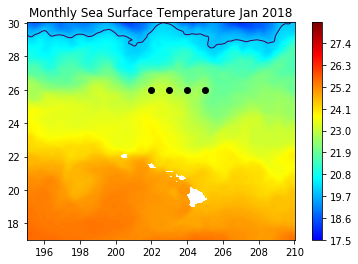

In [18]:
plt.contourf(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:], levs,cmap=cm)
#plot the color scale
plt.colorbar()
#example of how to add points to the map
plt.scatter(range(202,206),np.repeat(26,4),c='black')
#example of how to add a contour line
plt.contour(ds.longitude, ds.latitude, ds.analysed_sst[0,:,:],levels=[20],linewidths=1)
#plot title
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

### Plotting a time series

Let's pick the following box : 18-23N, 200-206E. We are going to generate a time series of mean SST within that box.

- first, let subset our data:

In [20]:
#lat_bnds, lon_bnds = [18, 23], [200, 206]
#da=ds.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds))
da=ds.sel(latitude=slice(18, 23), longitude=slice(200,206))

- let's plot the subset:

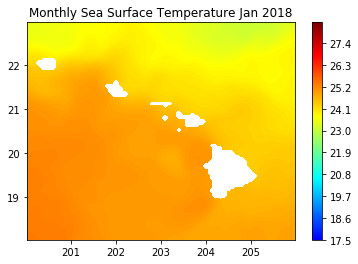

In [21]:
plt.contourf(da.longitude, da.latitude, da.analysed_sst[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("Monthly Sea Surface Temperature " + dates[0].strftime('%b %Y'))
plt.show()

- let's compute the monthly mean over the bounding region:

In [22]:
res=np.mean(da.analysed_sst,axis=(1,2))

- let's plot the time-series:

Text(0, 0.5, 'SST (ºC)')

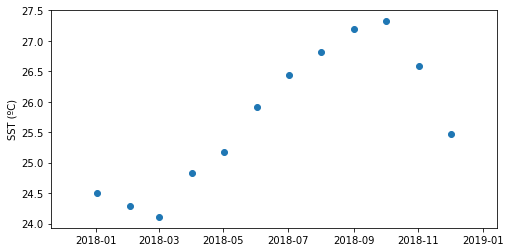

In [23]:
plt.figure(figsize=(8,4))
plt.scatter(dates,res)
plt.ylabel('SST (ºC)')

### Creating a map of average SST over a year

- let's compute the yearly mean for the region:

In [24]:
mean_sst=np.mean(ds.analysed_sst,axis=0)

In [25]:
mean_sst.shape

(261, 301)

- let's plot the map of the 2018 average SST in the region:

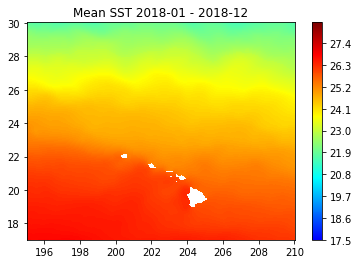

In [26]:
plt.contourf(ds.longitude, ds.latitude, mean_sst, levs,cmap=cm)
plt.colorbar()
plt.title("Mean SST " + dates[0].strftime('%Y-%m')+' - '+dates[11].strftime('%Y-%m'))
plt.show()